In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### `uncontrolled.csv` is from a run with a constant tolerance of 2 degrees. It serves as baseline data and is included in the repository for reference. If changes are made to the framework, it should be replaced or removed.

In [2]:
uncontrolled = pd.read_csv('uncontrolled.csv', index_col=0)
uncontrolled.index = pd.DatetimeIndex(uncontrolled.index)
uncontrolled = uncontrolled/1e3

### Secondary transformer (entire circuit) demand. Notice the peak-shifting behavior caused by the transactive control.

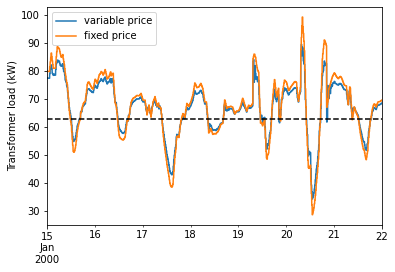

In [3]:
power = pd.read_csv('gridlab-d/power_log.csv', skiprows = 7, index_col = 0)
power.index.name = power.index.name.replace('# ', '')
power.columns = power.columns.str.replace(':measured_real_power', '')
power.index = pd.DatetimeIndex(power.index.str.replace(' PST', ''))
power = power/1e3
start = power.index[0]+pd.Timedelta(days=14)
stop = start+pd.Timedelta(days=7)

fig, ax = plt.subplots()
power.loc[start:stop].N2.plot(ax=ax)
uncontrolled.loc[start:stop].N2.plot(ax=ax)
ax.hlines(
    y=uncontrolled.N2.mean(), 
    xmin=start, 
    xmax=stop, 
    linestyles='--', 
    colors='black'
)
ax.legend(['variable price', 'fixed price'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')
plt.show()

### Node voltages. The closer to 120 V, the better; the sag seen here is due to the loads being oversized for the circuit. This is more of an issue during winter months for buildings with electric heating. Selecting smaller RBSA cases will likely give better results. Imaginary parts also available in `gridlab-d/Volt_log.csv`.

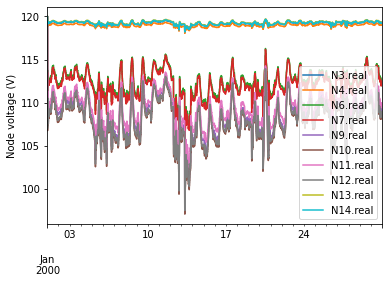

In [4]:
v = pd.read_csv('gridlab-d/Volt_log.csv', skiprows = 7, index_col = 0)
v.index.name = v.index.name.replace('# ', '')
v.columns = v.columns.str.replace(':measured_voltage_1', '')
v.index = pd.DatetimeIndex(v.index.str.replace(' PST', ''))

fig, ax = plt.subplots()
v[[column for column in v.columns if column.endswith('.real')]].plot(ax=ax)
ax.set_ylabel('Node voltage (V)')
ax.set_xlabel('')
plt.show()

### Real power losses, computed by subtracting the sum of the building nodes' consumption from the transformer consumption. For now, this data scales with demand, but that may change as more detailed ZIP coefficients and power factors are added.

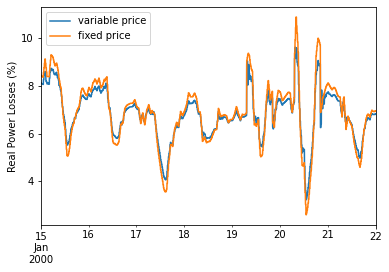

In [5]:
fig, ax = plt.subplots()
for df in [power, uncontrolled]:
    df = df.loc[start:stop]
    (100*(df.N2 - df.drop(columns='N2').sum(axis='columns'))/df.N2).plot(ax=ax)
ax.set_ylabel('Real Power Losses (%)')
ax.legend(['variable price', 'fixed price'])
ax.set_xlabel('')
plt.show()